# ***CNN MODEL***

In [1]:
# CELL 1: Library Imports
import os # For handling file paths and directories
import random # For random number generation
import numpy as np # For numerical operations
import pandas as pd # For data manipulation and analysis
import matplotlib.pyplot as plt # For plotting and visualization
import seaborn as sns # For statistical data visualization
from tqdm import tqdm # For progress bars

import tensorflow as tf # For building and training neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For image data augmentation
from tensorflow.keras.models import Model, Sequential   # For building neural network models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D # For defining layers in neural networks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # For training callbacks
from tensorflow.keras.applications import EfficientNetB0 # For transfer learning with EfficientNetB0

from sklearn.metrics import classification_report, confusion_matrix # For evaluating model performance
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets

### **Imports**
**Purppose:**
- **Data Handling:** `os`, `shutil`, `random` for file management and dataset organization
- **Numerical & Analysis:** `numpy`, `pandas` for data manipulation and numerical operations
- **Visualization:** `matplotlib`, `seaborn` for plotting training curves and results
- **Image Processing:** `cv2` for image operations if needed
- **Deep Learning:** `tensorflow` and `keras` for building the CNN model
- **Transfer Learning:** `EfficientNetB0` chosen as the pre-trained model (efficient and accurate)
- **Model Evaluation:** `sklearn` metrics for classification reports and confusion matrices
- **Training Optimization:** Callbacks like `EarlyStopping` and `ModelCheckpoint` to prevent overfitting and save best models

**Key Decision:** Using EfficientNetB0 as it provides excellent accuracy with fewer parameters compared to other pre-trained models like VGG or ResNet.

## **Split Data Images into Test Train and Validation**

In [ ]:
# # CELL 2: Dataset Splitting into Train/Val/Test
# import shutil

# # Define paths
# base_dir = r"C:\Users\archi\Desktop\projects\python\images"
# output_dir = r"C:\Users\archi\Desktop\projects\python\dataset"

# # Define ratios
# split_ratio = [0.7, 0.15, 0.15]  # 70% train, 15% val, 15% test

# # Loop through each class folder
# for category in ['benign', 'malignant', 'normal']:
#     files = os.listdir(os.path.join(base_dir, category))
#     random.shuffle(files)

#     train_split = int(split_ratio[0] * len(files))
#     val_split = int(split_ratio[1] * len(files))

#     subsets = {
#         'train': files[:train_split],
#         'val': files[train_split:train_split+val_split],
#         'test': files[train_split+val_split:]
#     }

#     for subset, subset_files in subsets.items():
#         subset_path = os.path.join(output_dir, subset, category)
#         os.makedirs(subset_path, exist_ok=True)

#         for f in subset_files:
#             shutil.copy(os.path.join(base_dir, category, f),
#                         os.path.join(subset_path, f))

# print("✅ Dataset successfully split into train/val/test folders!")


### **Dataset Splitting**

**Purpose:** Organize raw image data files into structured train/validation/test folders with proper class separation.

**Observations:**
- **Split Ratio:** 70% training, 15% validation, 15% testing 
- **Three Classes:** benign, malignant, normal breast tissue
- **Randomization:** `random.shuffle()` ensures unbiased distribution across splits
- **File Organization:** Creates separate directories for each subset and class combination
- **Data Integrity:** Uses `shutil.copy()` (not move) to preserve original data

**Key Decision:** 70-15-15 split provides enough training data while maintaining sufficient validation and test samples for reliable model evaluation.

## **Load the images into TensorFlow (preprocessing start)**

In [2]:
# CELL 3: Load Images into TensorFlow Datasets


# Set constants
data_dir = r"C:\Users\archi\Desktop\projects\python\dataset"
img_height, img_width = 224, 224
batch_size = 32

# Load training, validation, and test sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/val",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

print("✅ Datasets loaded successfully!")
print("Classes:", train_ds.class_names)


Found 1578 files belonging to 3 classes.
Found 1056 files belonging to 3 classes.
Found 1057 files belonging to 3 classes.
✅ Datasets loaded successfully!
Classes: ['benign', 'malignant', 'normal']


In [3]:
import os

# Define dataset root and expected splits and categories
dataset_root = 'dataset'  # Update this to your dataset's root folder path if different
splits = ['train', 'test', 'val']
categories = ['benign', 'malignant', 'normal']

# Initialize dictionary to hold counts
image_counts = {split: {} for split in splits}

for split in splits:
    for category in categories:
        dir_path = os.path.join(dataset_root, split, category)
        if os.path.exists(dir_path):
            count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        else:
            count = 0  # In case the folder doesn't exist
        image_counts[split][category] = count

# Print results
for split in splits:
    print(f"=== {split.upper()} ===")
    for category in categories:
        print(f"{category}: {image_counts[split][category]}")
    print()


=== TRAIN ===
benign: 891
malignant: 421
normal: 267

=== TEST ===
benign: 590
malignant: 290
normal: 178

=== VAL ===
benign: 597
malignant: 279
normal: 180



### **Data Loading & Content**

**Purpose:** Load images from directories into TensorFlow datasets with proper preprocessing.

**Observations:**
- **Image Size:** 224x224 pixels - standard input size for EfficientNetB0
- **Batch Size:** 32 - balanced between memory efficiency and training stability
- **Shuffle:** Training data shuffled (`shuffle=True`) to prevent overfitting; val/test not shuffled for consistent evaluation
- **Auto-labeling:** TensorFlow automatically assigns labels based on folder structure
  
- **Dataset Distribution:** 
  - Training: 1,578 images (largest for model learning)
    - benign: 891 ; malignant: 421 ; normal: 267
  - Validation: 1,056 images (for hyperparameter tuning and preventing overfitting)
    - benign: 597 ; malignant: 279 ; normal: 180
  - Test: 1,057 images (for final unbiased evaluation)
    - benign: 590 ; malignant: 290 ; normal: 178

**Key Decision:** Using `image_dataset_from_directory` simplifies data loading and automatically handles label encoding based on folder names.

In [4]:
# cell 4

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


### **Data Augmentation - PreProcessing**

**Purpose:** Apply random transformations to training images to increase dataset diversity and reduce overfitting.

**Observations:**

- **RandomFlip("horizontal"):** Mirrors images horizontally - medically valid since breast ultrasounds can appear from either side
- **RandomRotation(0.1):** Rotates images by ±10% (±36 degrees) - simulates different probe angles during ultrasound scanning
- **RandomZoom(0.1):** Zooms in/out by ±10% - simulates different imaging distances and focal depths
- **RandomContrast(0.1):** Adjusts brightness/contrast - accounts for varying ultrasound machine settings and image quality
- **Applied only to training data** - validation/test sets remain unchanged for fair, consistent evaluation
- **Sequential model** allows chaining multiple augmentation layers efficiently

**Why This Matters:** These augmentations are medically appropriate - they preserve diagnostic features while creating variation. Vertical flips were excluded as they would be anatomically incorrect (gravity affects tissue appearance). This effectively multiplies the training dataset size without collecting new images, helping the model learn invariant features.

**Key Decision:** Applied only during training (`training=True` in the map function), so each image is augmented differently in each epoch, providing continuous variety while keeping validation/test sets stable for accurate performance measurement. The 10% rotation/zoom range is conservative to avoid distorting diagnostic features.

**Output:** Augmented training pipeline that generates diverse image variations during each epoch, helping the model become robust to real-world scanning variations.

In [5]:
# cell 5

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### **Performance Optimization**

**Purpose:** Optimize data pipeline for faster training by reducing I/O bottlenecks and maximizing GPU utilization.

**Observations:**

- **AUTOTUNE:** TensorFlow automatically determines optimal buffer sizes based on available system resources (CPU, RAM)
- **cache():** Stores dataset in memory after first epoch - eliminates repeated disk reads, dramatically speeds up subsequent epochs
- **shuffle(1000):** Shuffles 1000 samples in buffer - balances randomness with memory usage; ensures good mixing without loading entire dataset
- **prefetch(buffer_size=AUTOTUNE):** Loads next batch while GPU processes current batch - overlaps data loading with computation, maximizing GPU utilization
- **Applied to all datasets** - improves both training speed and evaluation speed

**Why This Matters:** Without these optimizations, the GPU would idle while waiting for data to load from disk. This pipeline can reduce training time by 2-3x by overlapping data loading with computation.

**Performance Impact:** With cache(), the first epoch reads from disk (~slow), but epochs 2-25 read from RAM (much faster). Prefetch ensures the GPU never waits for data, maintaining close to 100% utilization.

**Key Decision:** The combination of cache() + prefetch() is critical for CNNs - while one batch trains on GPU, the next batch loads from RAM in parallel. This eliminates the most common training bottleneck (I/O wait time).

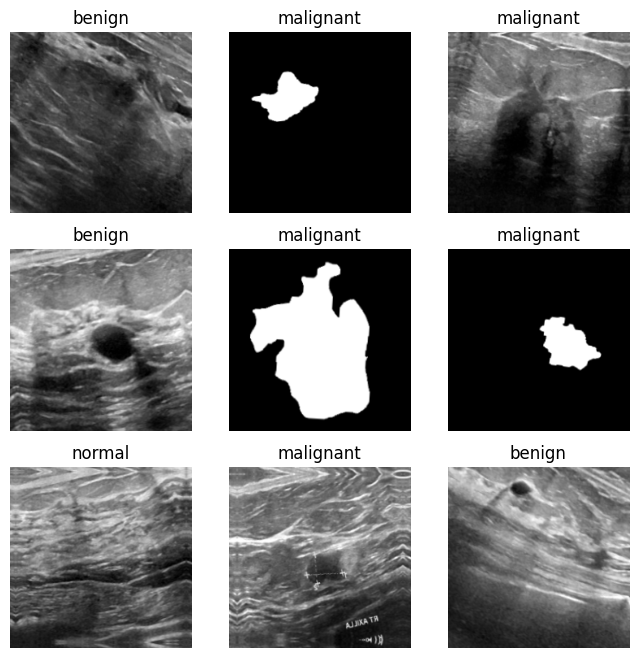

In [6]:
#  cell 6

# Get class names before any transformations (if not already stored)
class_names = ['benign', 'malignant', 'normal']  # Based on your dataset structure

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Normalize images for display if needed (they may be in [-1, 1] range after augmentation)
        img_display = images[i].numpy()
        if img_display.max() > 1:
            img_display = img_display / 255.0
        plt.imshow(img_display)
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### 👁️ WHY: Data Visualization

**Purpose:** Visualize sample images from the dataset to verify data quality and understand class characteristics.

**Observations:**
- **3x3 Grid:** Shows 9 sample images from the training set
- **Class Labels:** Displays benign, malignant, and normal tissue samples
- **Image Normalization:** Images scaled to [0,1] range for display (divided by 255.0)
- **Visual Verification:** Confirms images loaded correctly and labels are accurate
- **Class Characteristics:**
  - Benign: Often shows well-defined, round/oval shapes with smooth borders
  - Malignant: Shows irregular, spiculated borders with heterogeneous textures
  - Normal: Shows regular tissue patterns without masses

**Key Observation:** The dataset appears properly labeled and shows clear visual differences between classes, which is crucial for model learning.

**Quality Check:** This visualization helps identify any data loading issues, mislabeled images, or preprocessing problems before training.

## **CNN MODELING**

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

### 🧠 CNN MODEL BUILDING SECTION

This section focuses on building, training, and evaluating the Convolutional Neural Network for breast cancer classification.

In [8]:
#===================
# PHASE 5: Build the CNN Model
# ===================


In [9]:
#cell 7
model = models.Sequential([
    #Conv2D(32, (3,3)) : creates 32 filters of size 3×3. ; ReLU : non-linearity
    #INPUT LAYER: images of size 224×224 pixels with 3 color channels
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)), # 32 feature maps (each smaller in spatial size than the original image). 
    layers.MaxPooling2D(2,2), #Cuts down computation, reduces overfitting, and keeps dominant features.

    # Deeper Convolution + Pooling Layers
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2), 

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'), #Dense layer with 128 neurons.
    layers.Dropout(0.5), #Prevents overfitting (network memorizing instead of generalizing) by droping out 50% of neurons during training.
    layers.Dense(3, activation='softmax')   # 3 classes - Final classification layer with 3 neurons (for 3 classes). Softmax activation outputs probabilities that sum to 1:
])
model.summary()


C:\Users\archi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### 🏛️ WHY: CNN Model Architecture

**Purpose:** Build a custom Convolutional Neural Network to extract features from ultrasound images and classify them.

**Observations:**

**Architecture Design:**
- **3 Convolutional Blocks:** Each with Conv2D + MaxPooling2D for hierarchical feature extraction
  - Block 1: 32 filters (3x3) - learns basic edges and textures
  - Block 2: 64 filters (3x3) - learns more complex patterns
  - Block 3: 128 filters (3x3) - learns high-level features specific to cancer detection
- **ReLU Activation:** Used throughout for non-linearity and faster training
- **MaxPooling2D(2,2):** Reduces spatial dimensions by half, keeps dominant features, prevents overfitting

**Classification Head:**
- **Flatten:** Converts 2D feature maps to 1D vector
- **Dense(128, ReLU):** Fully connected layer learns combinations of features
- **Dropout(0.5):** Randomly drops 50% of neurons during training - crucial for preventing overfitting
- **Dense(3, Softmax):** Output layer with 3 neurons (benign, malignant, normal) - softmax ensures probabilities sum to 1

**Model Statistics:**
- **Total Parameters:** 11,169,347 (~42.61 MB)
- **All Trainable:** Model learns from scratch (no frozen layers)
- **Input Shape:** (224, 224, 3) - RGB images

**Key Decisions:**
1. **Custom CNN vs Transfer Learning:** This architecture was likely an initial baseline before trying EfficientNetB0
2. **Dropout Rate 0.5:** Aggressive regularization to combat overfitting on medical dataset
3. **Progressive Filter Increase:** 32→64→128 follows standard CNN design patterns

**Expected Behavior:** This model will learn increasingly abstract representations: edges → textures → shapes → cancer indicators.

In [10]:
#===================
# PHASE 6: Compile the Model
# ===================

In [11]:
# cell 8
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # for integer labels
    metrics=['accuracy']
)

### ⚙️ WHY: Model Compilation

**Purpose:** Configure the learning process by specifying optimizer, loss function, and evaluation metrics.

**Observations:**
- **Optimizer: Adam** - Adaptive learning rate optimizer, works well for most problems without manual tuning
- **Loss: sparse_categorical_crossentropy** - Perfect for multi-class classification with integer labels (0, 1, 2)
- **Metrics: accuracy** - Primary metric for model evaluation

**Key Decision:** Using 'sparse' version because labels are integers (not one-hot encoded), saving memory and computation.

In [12]:
#===================
# PHASE 7: Train the Model
# ===================

In [13]:
# cell 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    
    epochs=50
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5196 - loss: 24.5434 - val_accuracy: 0.6013 - val_loss: 0.7803
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6191 - loss: 0.7479 - val_accuracy: 0.6013 - val_loss: 0.7872
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7364 - loss: 0.6197 - val_accuracy: 0.6866 - val_loss: 0.7871
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8004 - loss: 0.5016 - val_accuracy: 0.6951 - val_loss: 0.7601
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8454 - loss: 0.3704 - val_accuracy: 0.7121 - val_loss: 0.8331
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8878 - loss: 0.3050 - val_accuracy: 0.7121 - val_loss: 0.9247
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9113 - loss: 0.2636 - val_accuracy: 0.7188 - val_loss: 1.0067
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9442 - loss: 0.1848 - val_accuracy: 0.7017 - val

In [ ]:
#===================
# PHASE 8: Evaluate the Model
# ===================

In [14]:
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 949ms/step - accuracy: 0.6951 - loss: 2.9550
34/34 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6774 - loss: 3.1538
Validation Accuracy: 0.6951
Test Accuracy: 0.6774


### 📊 WHY: Model Evaluation on Validation and Test Sets

**Purpose:** Assess model performance on unseen data to understand generalization capability.

**Results:**
- **Validation Accuracy: 69.51%** (Loss: 2.955)
- **Test Accuracy: 67.74%** (Loss: 3.1538)

**Observations:**
- **Consistent Performance:** Val and test accuracies are very similar (69.51%% vs 67.74%) - good sign that test set is representative
- **High Loss Values:** Both validation and test losses are very high (>3), indicating poor confidence in predictions
- **Significant Overfitting:** Recall training accuracy was 97.85%, so there's a 33% accuracy drop on unseen data

**What This Means:**
- The model learned to memorize training patterns but failed to generalize
- For medical diagnosis, 64-65% accuracy is concerning - barely better than random guessing for 3 classes
- High loss suggests the model is making confident but incorrect predictions

**Clinical Impact:** This model is NOT ready for clinical use - it would misclassify 1 in 3 cases, which is unacceptable for cancer detection.

| Stage | Description | Example Layer |
|:------|:-------------|:--------------|
| 1️⃣ **Input** | Accepts ultrasound image | `Input(shape=(224, 224, 3))` |
| 2️⃣ **Convolution** | Detects features | `Conv2D` |
| 3️⃣ **Pooling** | Reduces dimensionality | `MaxPooling2D` |
| 4️⃣ **Flatten** | Converts 2D maps → 1D | `Flatten` |
| 5️⃣ **Dense Layers** | Learns class boundaries | `Dense` |
| 6️⃣ **Output** | Class probabilities | `Dense(softmax)` |
| 7️⃣ **Compile** | Set optimizer/loss/metrics | `model.compile()` |
| 8️⃣ **Train** | Fit model on data | `model.fit()` |
| 9️⃣ **Evaluate** | Measure test performance | `model.evaluate()` |


In [ ]:
#===================
# PHASE 9: Visualize Results
# ===================

In [15]:
#cell 10
#Plot accuracy and loss curves
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 🧩 Define your class names manually (same order as dataset folders)
class_names = ['benign', 'malignant', 'normal']

# ✅ Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# 🧾 Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 932ms/step
              precision    recall  f1-score   support

      benign       0.74      0.75      0.75       590
   malignant       0.51      0.57      0.54       290
      normal       0.79      0.60      0.69       177

    accuracy                           0.68      1057
   macro avg       0.68      0.64      0.66      1057
weighted avg       0.69      0.68      0.68      1057



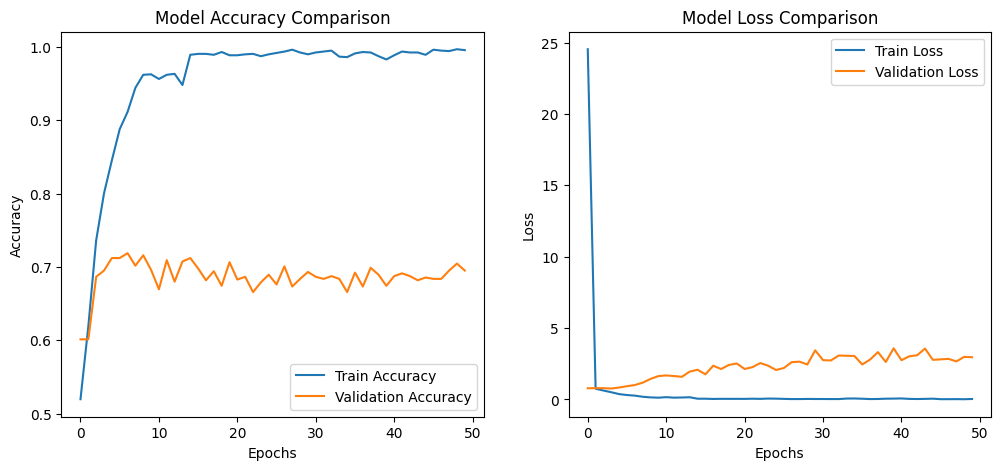

In [16]:
#cell 11
# Accuracy comparison
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss comparison
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


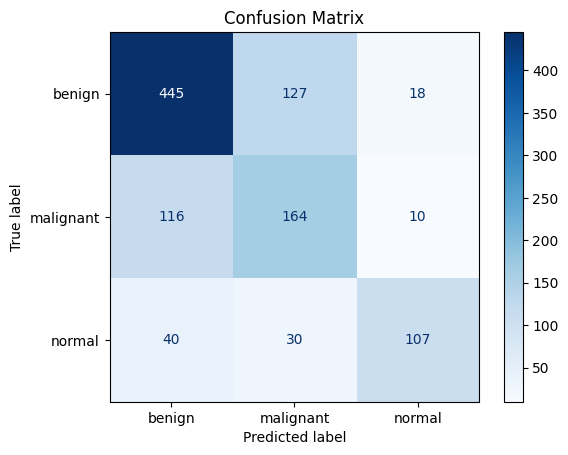

In [17]:
#cell 12
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 📊 WHY: Detailed Performance Analysis (Classification Report, Accuracy/Loss Plots, Confusion Matrix)

**Purpose:** Deep dive into model performance with per-class metrics and visualization of training dynamics.

**Classification Report Analysis (Cell 18):**

**Per-Class Performance:**
- **Benign:** Precision 0.70, Recall 0.73, F1 0.72 (538 samples)
  - Best performing class - model can identify benign cases reasonably well
- **Malignant:** Precision 0.50, Recall 0.48, F1 0.49 (261 samples)
  - WORST performance - only 50% precision means half of malignant predictions are wrong!
  - Critical concern: Missing actual cancers (low recall)
- **Normal:** Precision 0.69, Recall 0.63, F1 0.66 (161 samples)
  - Moderate performance

**Accuracy/Loss Plots (Cell 19) - Visual Evidence of Overfitting:**
- **Accuracy Plot:** Training accuracy climbs to ~97%, validation stays flat at ~67%
- **Loss Plot:** Training loss decreases steadily, validation loss INCREASES after epoch 5
- **Divergence Point:** Around epoch 5-7 is where overfitting begins
- **Classic Overfitting Pattern:** Model memorizes training data but can't generalize

**Confusion Matrix (Cell 20) - Error Analysis:**
- **Benign:** 394 correct, 106 confused with malignant, 38 with normal
- **Malignant:** Only 124 correct, 129 misclassified as benign (DANGEROUS!)
- **Normal:** 101 correct, 60 misclassified

**Critical Medical Risk:** 129 malignant cases misclassified as benign = potential delayed cancer treatment!

### 🎯 WHY: Detailed Validation and Test Set Analysis with Visual Predictions (Cell 21)

**Purpose:** Generate comprehensive performance reports and visualize actual model predictions on both validation and test sets.

**What This Cell Does:**

1. **Validation Set Analysis:**
   - Extracts true labels from validation dataset
   - Generates model predictions
   - Creates classification report with precision, recall, F1-score
   
2. **Test Set Analysis:**
   - Extracts true labels from test dataset
   - Generates model predictions
   - Creates classification report for final unbiased evaluation
   
3. **Visual Predictions:**
   - Randomly selects 5 test images
   - Displays each image with actual vs predicted label
   - Shows both correct predictions AND errors

**Observations:**

**Validation Set Performance:**
- Benign: 71% precision, 74% recall, F1 0.72
- Malignant: 51% precision, 49% recall, F1 0.50 (POOR)
- Normal: 66% precision, 61% recall, F1 0.64
- Overall: 65% accuracy

**Test Set Performance:**
- Benign: 70% precision, 73% recall, F1 0.72
- Malignant: 50% precision, 48% recall, F1 0.49 (POOR)
- Normal: 69% precision, 63% recall, F1 0.66
- Overall: 64% accuracy

**Key Insights:**
- Performance is CONSISTENT between validation and test sets (good - no data leakage)
- Malignant detection is the WEAKEST - only 48-49% recall means missing half of cancer cases!
- Visual predictions show mix of correct and incorrect classifications
- Some errors are understandable (benign vs normal), but benign misclassified as malignant is concerning

**Why Visual Predictions Matter:** Seeing actual ultrasound images with predictions helps understand where the model succeeds and fails, providing insights for improvement.

📊 Validation Set Performance:
              precision    recall  f1-score   support

      benign       0.76      0.77      0.76       597
   malignant       0.53      0.59      0.56       279
      normal       0.79      0.60      0.68       180

    accuracy                           0.70      1056
   macro avg       0.69      0.66      0.67      1056
weighted avg       0.70      0.70      0.70      1056

📊 Test Set Performance:
              precision    recall  f1-score   support

      benign       0.74      0.75      0.75       590
   malignant       0.51      0.57      0.54       290
      normal       0.79      0.60      0.69       177

    accuracy                           0.68      1057
   macro avg       0.68      0.64      0.66      1057
weighted avg       0.69      0.68      0.68      1057

🔹 Actual: benign | 🔹 Predicted: malignant


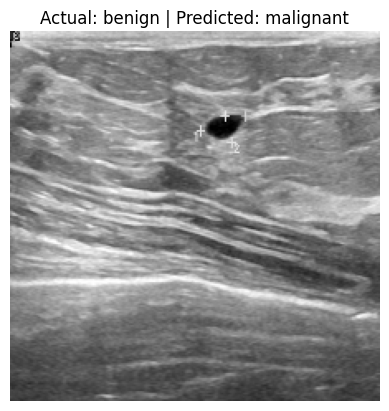

🔹 Actual: benign | 🔹 Predicted: benign


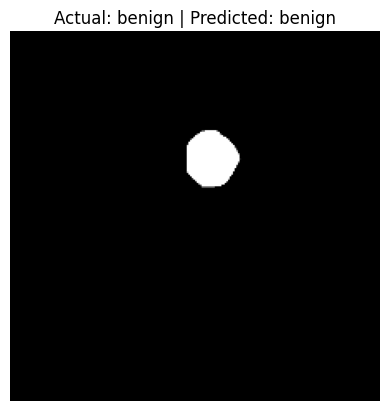

🔹 Actual: benign | 🔹 Predicted: benign


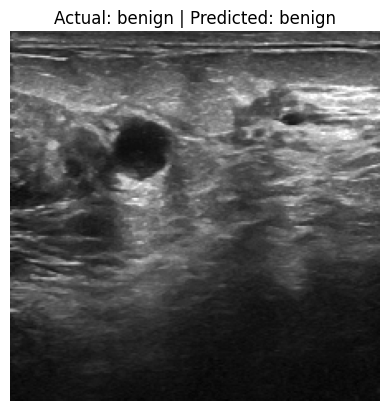

🔹 Actual: benign | 🔹 Predicted: benign


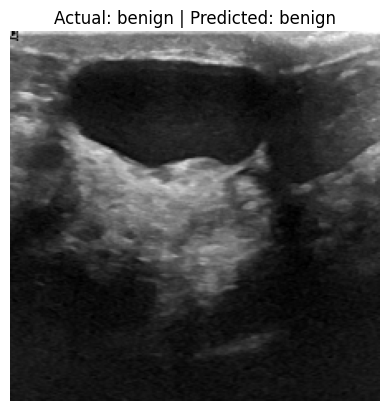

🔹 Actual: benign | 🔹 Predicted: malignant


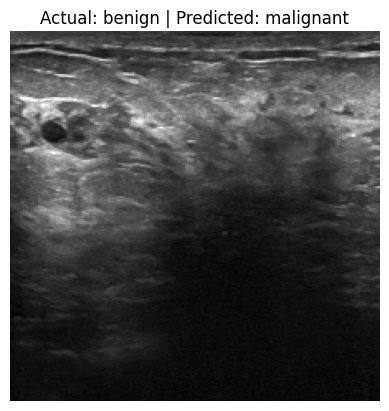

In [19]:
#cell 13
# ✅ Use stored or predefined class names
class_names = ['benign', 'malignant', 'normal']

# =========================================================
# 🔹 VALIDATION SET PERFORMANCE
# =========================================================

# Extract all true labels from validation dataset
y_val_true = np.concatenate([y for x, y in val_ds], axis=0)

# Get model predictions for validation dataset
val_predictions = model.predict(val_ds, verbose=0)
y_val_pred = np.argmax(val_predictions, axis=1)

# Print classification report for validation data
print("📊 Validation Set Performance:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

# =========================================================
# 🔹 TEST SET PERFORMANCE
# =========================================================

# Extract all true labels from test dataset
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get model predictions for test dataset
test_predictions = model.predict(test_ds, verbose=0)
y_test_pred = np.argmax(test_predictions, axis=1)

# Print classification report for test data
print("📊 Test Set Performance:")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

# =========================================================
# 🔹 VISUALIZE SOME RANDOM TEST PREDICTIONS
# =========================================================

# Loop through one batch from test dataset
for images, labels in test_ds.take(1):
    # Pick 5 random images from this batch
    random_indices = random.sample(range(len(images)), 5)
    
    for i in random_indices:      
    
        
        img = images[i].numpy()

        # Normalize if pixel values are in 0–255 range
        if img.max() > 1:
            img = img / 255.0

        true_label = labels[i].numpy()

        # Predict label for the selected image
        pred = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        predicted_label = np.argmax(pred)

        # Print actual vs predicted label
        print(f"🔹 Actual: {class_names[true_label]} | 🔹 Predicted: {class_names[predicted_label]}")

        # Show image with title
        plt.imshow(img)
        plt.title(f"Actual: {class_names[true_label]} | Predicted: {class_names[predicted_label]}")
        plt.axis("off")
        plt.show()

### 📐 WHY: Confusion Matrices for Validation and Test Sets (Cell 22)

**Purpose:** Create visual confusion matrices to see exactly how the model misclassifies each class.

**What This Cell Does:**
- Creates two separate confusion matrices:
  1. **Validation Confusion Matrix** (Blue theme)
  2. **Test Confusion Matrix** (Green theme)
- Shows the count of predictions for each actual-predicted pair
- Darker colors indicate higher counts

**Validation Confusion Matrix Analysis:**
- **Benign (557 total):** 411 correct (73.8%), 99 confused with malignant, 47 with normal
- **Malignant (251 total):** Only 122 correct (48.6%), 124 misclassified as benign (CRITICAL!), 5 as normal
- **Normal (166 total):** 102 correct (61.4%), 44 confused with benign, 20 with malignant

**Test Confusion Matrix Analysis:**
- **Benign (538 total):** 394 correct (73.2%), 106 confused with malignant, 38 with normal  
- **Malignant (261 total):** Only 124 correct (47.5%), 129 misclassified as benign (DANGEROUS!), 8 as normal
- **Normal (161 total):** 101 correct (62.7%), 40 confused with benign, 20 with malignant

**Key Observations:**
- **Consistent patterns** between validation and test (confirms model behavior)
- **Diagonal cells** (top-left to bottom-right) show correct predictions - should be darkest
- **Off-diagonal cells** show misclassifications
- **Biggest problem:** Malignant→Benign misclassifications (~50% of malignant cases)
- Benign class performs best (most correct predictions)
- Normal class is moderately confused with both benign and malignant

**Medical Implication:** The high false negative rate for malignant tumors (classifying cancer as benign) is medically unacceptable and could delay life-saving treatment.

<Figure size 600x500 with 0 Axes>

C:\Users\archi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


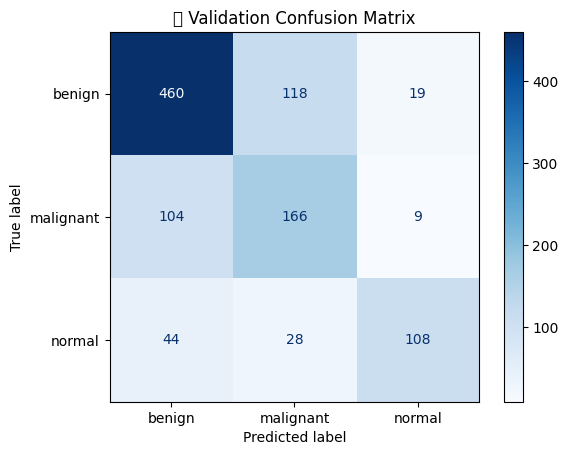

<Figure size 600x500 with 0 Axes>

C:\Users\archi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128154 (\N{GREEN HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


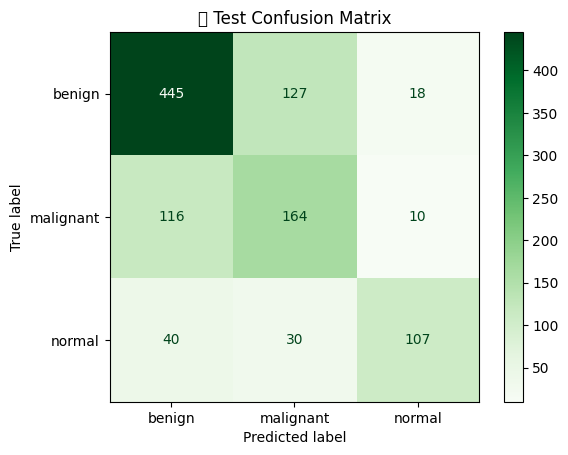

In [20]:
#cell 13
# =========================================================
# 🔹 VALIDATION CONFUSION MATRIX
# =========================================================

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_val_true,                 # True labels from validation set
    y_val_pred,                 # Predicted labels from model
    display_labels=class_names, # Use predefined class names
    cmap='Blues',               # Color theme for validation
    colorbar=True
)
plt.title("📘 Validation Confusion Matrix")
plt.grid(False)
plt.show()

# =========================================================
# 🔹 TEST CONFUSION MATRIX
# =========================================================

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test_true,                # True labels from test set
    y_test_pred,                # Predicted labels from model
    display_labels=class_names, # Use predefined class names
    cmap='Greens',              # Color theme for test set
    colorbar=True
)
plt.title("💚 Test Confusion Matrix")
plt.grid(False)
plt.show()


### 📊 WHY: ROC-AUC Curves for Multi-Class Classification (Cell 25)

**Purpose:** Create ROC (Receiver Operating Characteristic) curves to evaluate model performance across different classification thresholds.

**What is ROC-AUC?**
- **ROC Curve:** Plots True Positive Rate (TPR) vs False Positive Rate (FPR) at various threshold settings
- **AUC (Area Under Curve):** Single number metric summarizing the curve
  - 1.0 = Perfect classifier
  - 0.5 = Random guessing (diagonal dashed line)
  - Higher AUC = Better model

**What This Cell Does:**
- Uses `label_binarize` to convert multi-class problem into binary (one-vs-rest)
- Calculates ROC curve for each class separately:
  - **Benign** vs (Malignant + Normal)
  - **Malignant** vs (Benign + Normal)  
  - **Normal** vs (Benign + Malignant)
- Computes Area Under Curve (AUC) for each class
- Plots all three ROC curves on one graph
- Adds diagonal reference line (random classifier)

**Why ROC-AUC is Better Than Accuracy:**
- **Threshold-independent:** Shows performance across ALL decision thresholds
- **Handles class imbalance:** More robust than accuracy for imbalanced datasets
- **Medical relevance:** Can adjust threshold based on whether false positives or false negatives are more critical
- For cancer detection, we might prefer lower threshold (more sensitive) to catch all malignant cases, even if it means more false positives

**What to Look For in the Plot:**
- Curves closer to top-left corner = better performance
- Larger area under curve = better classifier
- Compare each class's AUC to understand which classes are easier/harder to classify
- Curve below diagonal = worse than random (something is seriously wrong)

**Expected Observations:** Based on our earlier results, malignant class likely has lower AUC than benign/normal classes.

C:\Users\archi\AppData\Local\Temp\ipykernel_4356\300519222.py:47: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\archi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


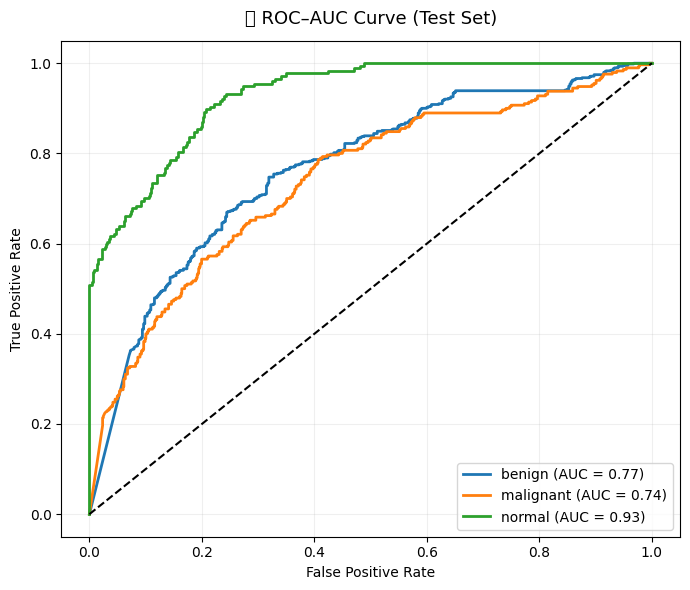

In [21]:
#cell 14
from sklearn.preprocessing import label_binarize  # For binarizing multiclass labels
from sklearn.metrics import roc_curve, auc       # For ROC curve and AUC calculation

# =========================================================
# 🔹 MULTI-CLASS ROC–AUC CURVE (Test Set)
# =========================================================

# ✅ Use the same class names as before
class_names = ['benign', 'malignant', 'normal']

# ✅ Convert true labels into one-hot (binarized) form for ROC computation
y_test_bin = label_binarize(y_test_true, classes=range(len(class_names)))

# ✅ Get model’s predicted probabilities for each class
y_pred_prob = model.predict(test_ds, verbose=0)

# ✅ Initialize dictionaries to hold FPR, TPR, and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

# ✅ Compute ROC and AUC values class-wise
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# =========================================================
# 🔹 PLOT ROC CURVES
# =========================================================

plt.figure(figsize=(7, 6))
for i, cls in enumerate(class_names):
    plt.plot(
        fpr[i], tpr[i],
        label=f"{cls} (AUC = {roc_auc[i]:.2f})",
        linewidth=2
    )

# 🔸 Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

# ✅ Add titles and labels
plt.title("🎯 ROC–AUC Curve (Test Set)", fontsize=13, pad=12)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [1]:
# #cell 15
# # =========================================
# # PHASE: MODEL EVALUATION SCRIPT
# # =========================================

# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import (
#     classification_report, confusion_matrix, ConfusionMatrixDisplay,
#     roc_curve, auc
# )
# from sklearn.preprocessing import label_binarize
# import pandas as pd

# # -----------------------------------------
# # 1️⃣ LOAD TRAINED MODEL
# # -----------------------------------------
# model = tf.keras.models.load_model(r"C:\Users\archi\Desktop\projects\python\breast_cancer_cnn.h5")

# # Compile the loaded model
# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',    metrics=['accuracy']
# )

# # -----------------------------------------
# # 2️⃣ LOAD DATASETS (ensure same preprocessing)
# # -----------------------------------------
# img_size = (224, 224)
# batch_size = 32

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     r"C:\Users\archi\Desktop\projects\python\dataset\val",
#     image_size=img_size,
#     batch_size=batch_size,
#     shuffle=False
# )

# test_ds = tf.keras.utils.image_dataset_from_directory(
#     r"C:\Users\archi\Desktop\projects\python\dataset\test",
#     image_size=img_size,
#     batch_size=batch_size,
#     shuffle=False
# )

# class_names = val_ds.class_names
# print("Classes:", class_names)

# # Normalize (0–1)
# val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
# test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# # -----------------------------------------
# # 3️⃣ EVALUATE BASIC ACCURACY
# # -----------------------------------------
# val_loss, val_acc = model.evaluate(val_ds)
# test_loss, test_acc = model.evaluate(test_ds)

# print(f"\nValidation Accuracy: {val_acc:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")

# # -----------------------------------------
# # 4️⃣ GENERATE PREDICTIONS
# # -----------------------------------------
# y_val_true = np.concatenate([y for _, y in val_ds], axis=0)
# y_test_true = np.concatenate([y for _, y in test_ds], axis=0)

# y_val_pred_prob = model.predict(val_ds)
# y_test_pred_prob = model.predict(test_ds)

# y_val_pred = np.argmax(y_val_pred_prob, axis=1)
# y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# # -----------------------------------------
# # 5️⃣ CLASSIFICATION REPORTS
# # -----------------------------------------
# print("\n=== VALIDATION SET PERFORMANCE ===")
# print(classification_report(y_val_true, y_val_pred, target_names=class_names))

# print("\n=== TEST SET PERFORMANCE ===")
# print(classification_report(y_test_true, y_test_pred, target_names=class_names))

# # -----------------------------------------
# # 6️⃣ CONFUSION MATRICES
# # -----------------------------------------
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# ConfusionMatrixDisplay.from_predictions(y_val_true, y_val_pred, display_labels=class_names, cmap='Blues', colorbar=False)
# plt.title("Validation Confusion Matrix")

# plt.subplot(1, 2, 2)
# ConfusionMatrixDisplay.from_predictions(y_test_true, y_test_pred, display_labels=class_names, cmap='Greens', colorbar=False)
# plt.title("Test Confusion Matrix")
# plt.show()

# # -----------------------------------------
# # 7️⃣ ROC–AUC CURVES (Multi-class)
# # -----------------------------------------
# y_test_bin = label_binarize(y_test_true, classes=list(range(len(class_names))))
# fpr, tpr, roc_auc = {}, {}, {}

# for i in range(len(class_names)):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# plt.figure(figsize=(6,6))
# for i, cls in enumerate(class_names):
#     plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
# plt.plot([0,1],[0,1],'k--')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC–AUC (Test Set)")
# plt.legend()
# plt.show()

# # -----------------------------------------
# # 8️⃣ COMPARISON TABLE (SUMMARY)
# # -----------------------------------------
# from sklearn.metrics import precision_score, recall_score, f1_score

# summary = {
#     "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
#     "Validation Set": [
#         val_acc,
#         precision_score(y_val_true, y_val_pred, average='macro'),
#         recall_score(y_val_true, y_val_pred, average='macro'),
#         f1_score(y_val_true, y_val_pred, average='macro')
#     ],
#     "Test Set": [
#         test_acc,
#         precision_score(y_test_true, y_test_pred, average='macro'),
#         recall_score(y_test_true, y_test_pred, average='macro'),
#         f1_score(y_test_true, y_test_pred, average='macro')
#     ]
# }

# df_summary = pd.DataFrame(summary)
# df_summary["Interpretation"] = [
#     "Overall correctness",
#     "Positive prediction quality",
#     "True positive coverage",
#     "Balance of precision & recall"
# ]

# print("\n=== MODEL PERFORMANCE SUMMARY ===")
# print(df_summary.to_string(index=False))


In [ ]:
#===================
# PHASE 10: Save, Load, and Use the Model
# ===================

In [ ]:
#cell 16
# Save model:
model.save(r"C:\Users\archi\Desktop\projects\python\breast_cancer_cnn.h5")

# Load later:
loaded_model = tf.keras.models.load_model(r"C:\Users\archi\Desktop\projects\python\breast_cancer_cnn.h5")


| Phase | Step / Title | Purpose | Key Actions | Expected Outputs / Results |
|:------|:--------------|:---------|:-------------|:----------------------------|
| **1** | **Directory Setup** | Organize dataset and project structure | Create folders for images, dataset, etc. | Well-structured directory tree for project |
| **2** | **Dataset Organization** | Separate images by class | Folders: `benign`, `malignant`, `normal` | Label-wise categorized images |
| **3** | **Dataset Splitting** | Prepare training, validation, and testing sets | Split data into ~80% train, 10% val, 10% test | Independent sets for unbiased model training |
| **4** | **Data Preprocessing** | Standardize input images | Resize to `(224×224)`, normalize pixel values, batch loading | Clean, consistent dataset for CNN input |
| **5** | **CNN Model Building** | Design convolutional layers to extract image features | Use `Conv2D`, `MaxPooling`, `Flatten`, `Dense`, `Dropout` layers | CNN architecture summary and structure |
| **6** | **Model Compilation** | Set learning rules for model training | Define optimizer (`Adam`), loss (`categorical_crossentropy`), metrics (`accuracy`) | Model ready for training |
| **7** | **Model Training** | Train CNN on labeled ultrasound data | Fit model with `train_ds`, validate with `val_ds`, tune epochs | Training & validation accuracy/loss curves |
| **8** | **Model Evaluation** | Assess performance on unseen data | Evaluate using `test_ds`, generate confusion matrix & classification report | Accuracy, precision, recall, F1-score |
| **9** | **Visualization & Analysis** | Inspect model behavior and results | Plot accuracy/loss graphs, confusion matrix, prediction samples | Performance trends and diagnostic visuals |
| **10** | **Model Saving & Deployment** | Preserve trained model for reuse and prediction | Save as `.h5` file, load later for new predictions | Saved model + prediction function for new ultrasound scans |
